This code is an implementation of Random Forest algorithm, based on scikit-learn package. Documentation can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [1]:
#Packages installation
#!pip install category_encoders

In [2]:
#Libraries import
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import matplotlib
import shap
import _pickle as cPickle
from sklearn import tree
from sklearn.impute import KNNImputer

In [3]:
#Input parameters
path_to_df = 'C:/Users/karol/Desktop/CS_SGH/ML/abt_app.xls'
name_of_df_sheet = 'Sheet1'
path_to_save_model = 'C:/Users/karol/Desktop/CS_SGH/ML/rf1.pkl'
test_size_value = 0.25
random_state = 1234

#Internal parameters
symbol_missing='Missing'
target_name = 'default12'
time_name = 'period'
intercept_name = 'Intercept'
id_vars = ['cid']
event_value = 'outstanding_bad'
all_value = 'outstanding'

In [4]:
#Data import
ef = pd.ExcelFile(path_to_df)
df = ef.parse(name_of_df_sheet)
df[intercept_name] = 1

In [5]:
#List of variables
vars = [var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']]

In [6]:
#How many mising values do we have in target variable?
df[target_name].isna().sum() 

2043

In [7]:
#Dropping mising values in target variable
df.dropna(subset=[target_name], inplace=True)

In [8]:
#Splitting into numeric and character variables
varsc = list(df[vars].select_dtypes(include='object'))
varsn = list(df[vars].select_dtypes(include='number'))

In [9]:
#Function for handling missing values (additional explaination some cells below)
def miss_values_manipulation(var, df=df, method='drop-feature', given_number=0, n_neighbors=5, random_state=1234, ncategories_int=5, minimum_share_int=0.03):
    if method=='drop-feature':
        df.drop(var, axis=1, inplace=True)
    elif method=='drop-observations':
        df.dropna(subset=[var], inplace=True)
    elif method=='input-mean':
        df[var].fillna(df[var].mean(), inplace = True)
    elif method=='input-median':
        df[var].fillna(df[var].median(), inplace = True)
    elif method=='input-mode':
        df[var].fillna(df[var].mode(), inplace = True)
    elif method=='input-min':
        df[var].fillna(df[var].min(), inplace = True)
    elif method=='input-max':
        df[var].fillna(df[var].max(), inplace = True)
    elif method=='input-given_number':
        df[var].fillna(given_number, inplace = True)
    elif method=='input-knn':
        knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
        df[var] = knn_imputer.fit_transform(df[[var]])
    elif method=='transform-string':
        df[var].fillna("NA", inplace = True)
    elif method=='transform-binning':
        #Function decoding bins
        def grp(x):
            res=np.NaN
            for i in range(len(labsn[var])):
                if i==0 and labsn[var][i]==-np.inf and labsn[var][i+1]!=np.inf and x<labsn[var][i+1]:                
                        res=i            
                if i==0 and labsn[var][i]==-np.inf and labsn[var][i+1]==np.inf and (-np.inf<=x<=np.inf):            
                        res=i
                if i>0 and labsn[var][i-1]!=-np.inf and labsn[var][i]==np.inf and labsn[var][i-1]<=x:            
                        res=i-1
                if i>0 and labsn[var][i-1]!=-np.inf and labsn[var][i]!=np.inf and labsn[var][i]!=symbol_missing and labsn[var][i-1]<=x<labsn[var][i+1]:        
                        res=i-1
                if labsn[var][i]==symbol_missing and math.isnan(x):
                        res=i-1
            return res
        
        labsn = {}
        miss_share=df[var].isnull().sum()/df[var].shape[0]
        miss_share=1-miss_share
        if miss_share<=0.00001:
            miss_share=1
        minimum_share=minimum_share_int/miss_share
        if minimum_share>0.5:
            minimum_share=0.5
        if minimum_share<minimum_share_int:
            minimum_share=minimum_share_int
        df_two_col=df[[target_name,var]].dropna(subset=[var]).copy()
        bins = [-np.inf, np.inf]
        clf = tree.DecisionTreeClassifier(
            max_leaf_nodes=ncategories_int,
            min_weight_fraction_leaf=minimum_share,
            random_state=random_state) 
        clf.fit(df_two_col[var].values.reshape(-1, 1), df_two_col[target_name])
        thresh = [round(s, 3) for s in clf.tree_.threshold if s != -2]  
        bins = bins + thresh 
        bins=sorted(bins)
        if df[var].isnull().sum()/df[var].shape[0] > minimum_share_int:
            bins=bins + [symbol_missing]
        labsn[var]=bins
        df[var]=df[var].apply(grp)

In [10]:
#Data missing exploration
for var in varsn:
    if df[var].isna().sum() != 0:
        print("Variable: " + str(var)
              + "\nMissings sum: " + str(df[var].isna().sum())
              + "\nMissings share: " + '{:.1%}'.format(df[var].isnull().sum()/df[var].shape[0])
              + "\nNumber of unique values: " + str(df[var].nunique())
              + "\nUnique values: " + str(df[var].unique())
              + "\n")

Variable: act_state_7_CMax_Due
Missings sum: 4616
Missings share: 34.5%
Number of unique values: 4
Unique values: [ 0.  1. nan  2.  3.]

Variable: ags6_Iqr_Cncr
Missings sum: 8584
Missings share: 64.2%
Number of unique values: 1
Unique values: [nan  0.]



For the correct operation of the algorithm, it is necessary to handle missing data in the dataset. The command in the cell above returns information about features that have missing data. In the next step, you need to transform them in some way. A function has been created to facilitate this - "miss_values_manipulation". The function needs two main parameters:
- var - name of variable to transform (so variable with missing data);
- method - way of dealing with missing data, possible values:
    - drop-feature - delete choosen variable
    - drop-observations - delete observations that have null values in choosen variable
    - input-mean - input mean for choosen variable instead of nulls
    - input-median - input median for choosen variable instead of nulls
    - input-mode - input mode for choosen variable instead of nulls
    - input-min - input minimum value for choosen variable instead of nulls
    - input-max - input maximum for choosen variable instead of nulls
    - input-given_number - input fix number instead of nulls, this number has to be passed to the function by "given_number" parameter
    - input-knn - input values using K-Nearest Neighbors algorithm (https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for choosen variable instead of nulls, this method required definition of number of neighbours to compute and this can be adjust by using "n_neighbors" parameter in this function
    - transform-string - transform all values to strings (all values will become a separate category)
    - transform-binning - binning values and make given number of categories, this method needs two parameters to be defined, same as in the main kod "ASB_step_by_step.ipnyb" - "ncategories_int" and "minimum_share_int"

In [11]:
#Parameters for "miss_values_manipulation" function

#Essential
method = "input-median"

#Non-essential
given_number = 0
n_neighbors = 5
ncategories_int = 5
minimum_share_int = 0.03

#Essential if loop below is not used
var = "act_state_7_CMax_Due"

In default setup of this workbook, loop has been introduced to handle all variables with missing data. Alternative way is to handle each variable independtly and treat them with different methods. To do that, below code with loop should be hashed and line below "#Execution of the function" should be unhashed.

In [12]:
#Loop for missing values manipulation over the dataframe
for var in varsn:
    if df[var].isna().sum() != 0:
        miss_values_manipulation(var, method=method, given_number=given_number, n_neighbors=n_neighbors, ncategories_int=ncategories_int, minimum_share_int=minimum_share_int)

#Execution of the function
#miss_values_manipulation(var, method=method, given_number=given_number, n_neighbors=n_neighbors, ncategories_int=ncategories_int, minimum_share_int=minimum_share_int)

In [13]:
#Update of variables lists after dealing with missing values
vars = [var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']]
varsc = list(df[vars].select_dtypes(include='object'))
varsn = list(df[vars].select_dtypes(include='number'))

In [14]:
#Categorical variables coding
enc = ce.BinaryEncoder(cols=varsc)
df_ce = enc.fit_transform(df[varsc])
varsc_ce = list(df_ce)

df_ce = enc.fit_transform(df)

vars_target_id_ce = varsn + varsc_ce + [target_name] + [time_name] + [intercept_name] + [event_value] + [all_value] + id_vars
vars_ce = varsn + varsc_ce

In [15]:
#Splitting for train and test datasets
train, test = train_test_split(df_ce[vars_target_id_ce], random_state = random_state, test_size=test_size_value)
print(train.shape, test.shape)

(10023, 36) (3341, 36)


In [16]:
#Input data
X = np.array(train[vars_ce])
Y = np.array(train[target_name])

X_test = np.array(test[vars_ce])
Y_test = np.array(test[target_name])

Random Forest algorithm can be adjusted using below hyperparameters:
- n_estimators - int, default=100 - the number of trees in the forest;
- criterion - {“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error” - the function to measure the quality of a split. Supported criteria are “squared_error” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, “absolute_error” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node, and “poisson” which uses reduction in Poisson deviance to find splits. Training using “absolute_error” is significantly slower than when using “squared_error”;
- max_depth - int, default=None - the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples;
- min_samples_split - int or float, default=2 - the minimum number of samples required to split an internal node:
    - if int, then consider min_samples_split as the minimum number,
    - if float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split;
- min_samples_leaf - int or float, default=1 - the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression
    - if int, then consider min_samples_leaf as the minimum number,
    - if float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node;
- min_weight_fraction_leaf - float, default=0.0 - the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided;
- max_features - {“sqrt”, “log2”, None}, int or float, default=1.0 - the number of features to consider when looking for the best split:
    - if int, then consider max_features features at each split,
    - if float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at each split,
    - if “auto”, then max_features=n_features,
    - if “sqrt”, then max_features=sqrt(n_features),
    - if “log2”, then max_features=log2(n_features),
    - if None or 1.0, then max_features=n_features;
- max_leaf_nodes - int, default=None - grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes;
- min_impurity_decrease - float, default=0.0 - a node will be split if this split induces a decrease of the impurity greater than or equal to this value. The weighted impurity decrease equation is the following:
        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

    where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.
    N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed;
- bootstrap - bool, default=True - whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree;
- oob_score - bool, default=False - whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True;
- n_jobs - int, default=None - the number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors;
- random_state - int, RandomState instance or None, default=None - controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features);
- verbose - int, default=0 - controls the verbosity when fitting and predicting;
- warm_start - bool, default=False - when set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest;
- ccp_alpha - non-negative float, default=0.0 - complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed;
- max_samples - int or float, default=None - if bootstrap is True, the number of samples to draw from X to train each base estimator:
    - if None (default), then draw X.shape[0] samples,
    - if int, then draw max_samples samples,
    - if float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0.0, 1.0].

In [17]:
#Model training
model = RandomForestRegressor(n_estimators = 30, random_state = random_state, max_depth = 9)
model.fit(X, Y)

RandomForestRegressor(max_depth=9, n_estimators=30, random_state=1234)

In [18]:
#Prediction calculation
Y_pred_train = model.predict(X)
Y_pred_test = model.predict(X_test)

In [19]:
#Output data
X = pd.DataFrame(X, columns = vars_ce)
Y = pd.DataFrame(Y, columns = list([target_name]))
X_test = pd.DataFrame(X_test, columns = vars_ce)
Y_test = pd.DataFrame(Y_test, columns = list([target_name]))

GINI TRAIN =  64.291%
GINI TEST =  44.176%


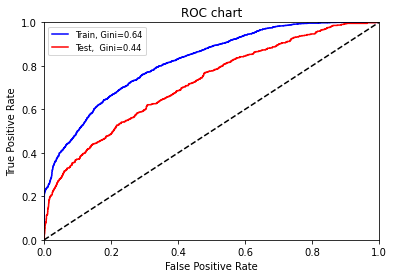

In [20]:
#Predictive power calculation
gini_train = 2 * roc_auc_score(Y,Y_pred_train)-1
print('GINI TRAIN = ', '{:.3%}'.format(gini_train))
gini_test  = 2 * roc_auc_score(Y_test,Y_pred_test)-1
print('GINI TEST = ', '{:.3%}'.format(gini_test))

fpr_train, tpr_train, thresholds_train = roc_curve(Y.values.ravel(), Y_pred_train)
fpr_test,  tpr_test,  thresholds_test  = roc_curve(Y_test.values.ravel(),  Y_pred_test)
fig = plt.figure()
plt.plot(fpr_train, tpr_train, 'blue', label='Train, Gini='+'{:4.2f}'.format(gini_train))
plt.plot(fpr_test,  tpr_test,  'red', label='Test,  Gini='+'{:4.2f}'.format(gini_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC chart')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

In [21]:
#Variables importance
importances = pd.DataFrame(columns = ["Variable", "Importance"])

for name, importance in zip(X, model.feature_importances_):
    new_row = pd.Series({'Variable':name, 'Importance':importance})
    importances = pd.concat([importances, new_row.to_frame().T], ignore_index=True)

importances.sort_values('Importance', ascending = False)

,Variable,Importance
16,ags3_Csev_all,0.286737
9,act_cus_cc,0.122147
15,ags30_Sum_CMin_Days,0.097306
0,app_income,0.082889
8,act_cus_utl,0.068569
4,app_spendings,0.058419
5,act_cus_n_loans_hist,0.037432
14,ags18_Nmiss_CMax_Due,0.031659
12,ags9_Pctl5_CMax_Days,0.023638
13,ags9_Min_CMin_Days,0.023098


In [22]:
#Saving the model
with open(path_to_save_model, 'wb') as f:
    cPickle.dump(model, f)

In [23]:
#Reading the model
with open(path_to_save_model, 'rb') as f:
    model2 = cPickle.load(f)
Y_pred_test2 = model2.predict(X_test)

X has feature names, but RandomForestRegressor was fitted without feature names


In [24]:
#Shapley reporting XAI
model_explainer = shap.TreeExplainer(model, X)
shaps_train=model_explainer(X, check_additivity=False )

 99%|===================| 9971/10023 [00:41<00:00]        

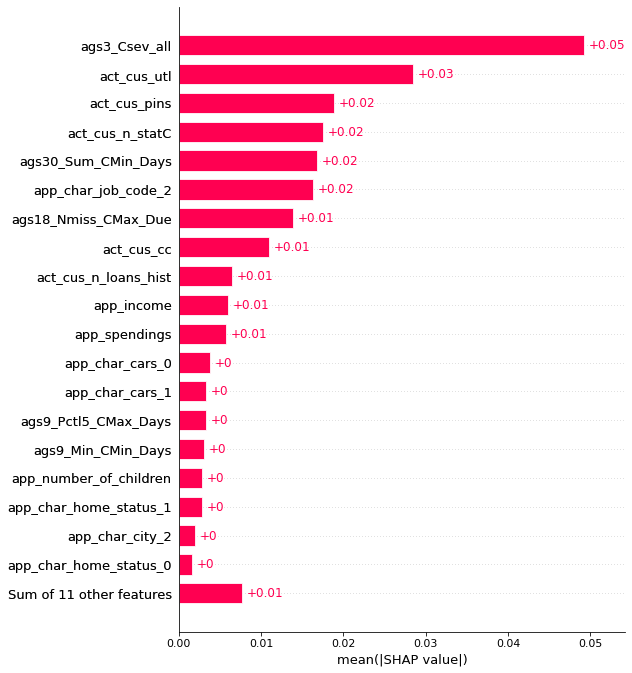

In [25]:
shap.plots.bar(shaps_train,max_display=20)

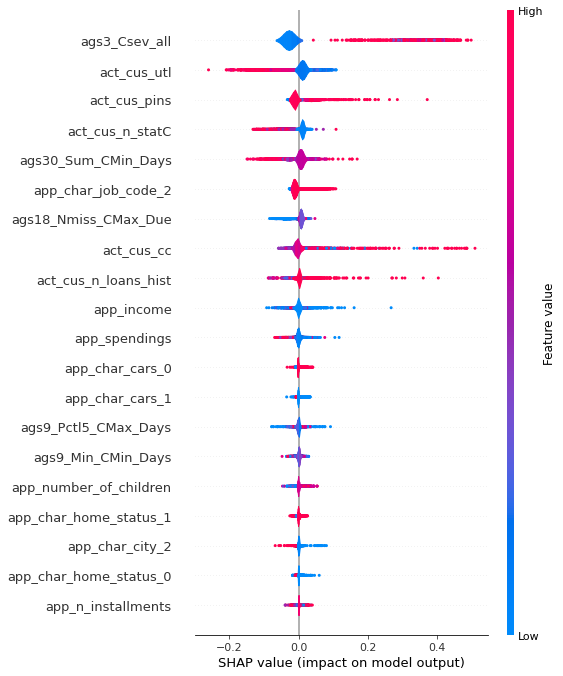

In [26]:
shap.summary_plot(shaps_train,X,plot_type='violin')

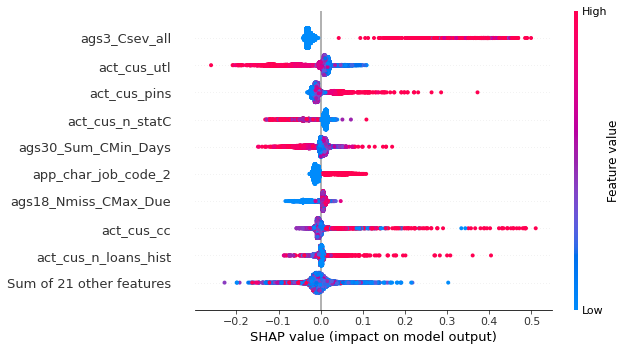

In [27]:
shap.plots.beeswarm(shaps_train)

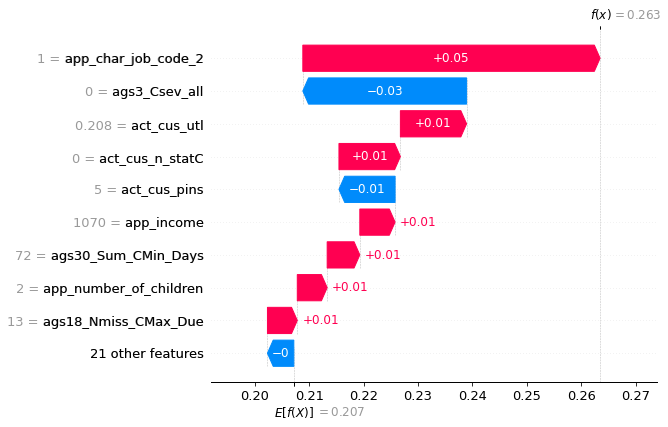

In [28]:
shap.waterfall_plot(shaps_train[0])

In [29]:
shap.initjs()
shap.plots.force(shaps_train[0])